In [50]:
import pandas as pd
import os

In [51]:
os.chdir(r'C:\Documents\GitHub\Challenge_OPSIE-SISE')

In [52]:
df = pd.read_csv('log_fw_3.csv', sep=';', header=None)
df

,0,1,2,3,4,5,6,7,8,9,10
0,2023-02-12 03:59:03,66.249.69.180,17.17.17.17,TCP,57630.0,443.0,1.0,PERMIT,eth0,NaN,6.0
1,2023-02-12 03:59:04,66.249.69.178,17.17.17.17,TCP,63808.0,443.0,1.0,PERMIT,eth0,NaN,6.0
2,2023-02-12 03:59:08,221.11.125.141,17.17.17.17,TCP,43123.0,2376.0,999.0,DENY,eth0,NaN,6.0
3,2023-02-12 03:59:18,183.136.225.42,17.17.17.17,TCP,8088.0,70.0,999.0,DENY,eth0,NaN,6.0
4,2023-02-12 03:59:20,38.32.112.34,17.17.17.17,TCP,6356.0,443.0,1.0,PERMIT,eth0,NaN,6.0
...,...,...,...,...,...,...,...,...,...,...,...
999995,2023-03-01 10:54:48,103.162.10.234,17.17.17.17,TCP,47468.0,443.0,1.0,PERMIT,eth0,NaN,6.0
999996,2023-03-01 10:54:50,1.164.127.35,17.17.17.17,TCP,35871.0,23.0,7.0,DENY,eth0,NaN,6.0
999997,2023-03-01 10:54:51,101.43.213.235,17.17.17.17,TCP,3096.0,23.0,7.0,DENY,eth0,NaN,6.0
999998,2023-03-01 10:54:53,66.249.68.3,17.17.17.17,TCP,41389.0,443.0,1.0,PERMIT,eth0,NaN,6.0


In [53]:
def to_datetime(x):
    return pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S.%f')

def prepare_log_data(log_data):
    log_data.columns = ['timestamp', 'IPsrc', 'IPdst', 'proto', 'portsrc', 'portdst', 'rule','action','7', '8','9']
    log_data.timestamp = to_datetime(log_data.timestamp)
    log_data.portdst = log_data.portdst.astype('object')
    return log_data

In [54]:
data = prepare_log_data(df)

In [55]:
data.pop('8')

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
999995   NaN
999996   NaN
999997   NaN
999998   NaN
999999   NaN
Name: 8, Length: 1000000, dtype: float64

In [56]:
data.portsrc = data.portsrc.astype('object')

In [57]:
data.dropna(inplace=True)

In [58]:
# create function of the above
def get_IPsrc_stats(data):
    IPsrc_deny = data[data.action == 'DENY'].groupby('IPsrc')['IPdst'].count().sort_values(ascending=False)
    IPsrc_deny = pd.DataFrame([IPsrc_deny.index,IPsrc_deny]).transpose()
    IPsrc_deny.columns = ['IPsrc', 'deny_count']
    mean_timestamp_byIP = data.groupby('IPsrc').timestamp.mean().reset_index(name='mean_timestamp').sort_values(by='mean_timestamp', ascending=False)
    IPsrc_counts = data.groupby('IPsrc').size().reset_index(name='counts').sort_values(by='counts', ascending=False)
    return IPsrc_deny, mean_timestamp_byIP, IPsrc_counts

# create function to create df_supervised with IPsrc_deny, mean_timestamp_byIP, IPsrc_counts

def create_unsupervised_df(data):
    IPsrc_deny, mean_timestamp_byIP, IPsrc_counts = get_IPsrc_stats(data)
    ratio = pd.merge(IPsrc_counts, IPsrc_deny, on='IPsrc')
    ratio['ratio_deny_total'] = ratio['deny_count'] / ratio['counts']
    df_supervised = pd.merge(IPsrc_counts, mean_timestamp_byIP, on='IPsrc')
    df_supervised = pd.merge(df_supervised, ratio[['IPsrc','ratio_deny_total']], on='IPsrc')


    df_supervised['hour'] = df_supervised.mean_timestamp.dt.hour
    return df_supervised

In [59]:
unsupervised_df = create_unsupervised_df(data)

unsupervised_df.head()

,IPsrc,counts,mean_timestamp,ratio_deny_total,hour
0,198.46.189.193,61889,2023-02-28 12:34:51.090387712,0.972758,12
1,89.248.165.195,19280,2023-02-17 07:01:07.696991744,1.0,7
2,89.248.163.70,10725,2023-02-18 12:01:29.414079232,0.999814,12
3,45.227.253.106,3434,2023-02-20 17:33:46.314793216,1.0,17
4,206.189.114.5,2970,2023-02-23 19:16:12.823232512,0.999663,19


In [60]:
## K-Means

In [61]:
import matplotlib.pyplot as plt

In [62]:
# Import MiniBatchKmeans 
from sklearn.cluster import MiniBatchKMeans


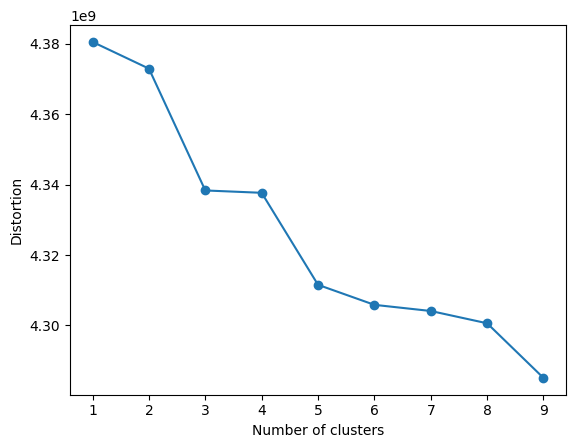

In [63]:
''' do a kmeans and write the best number of clusters'''

def kmeans(data, max_k=10):
    # Calculate distortion for a range of number of cluster
    distortions = []
    for i in range(1, max_k):
        km = MiniBatchKMeans(n_clusters=i,
                             init='random',
                             n_init=10,
                             max_no_improvement=10,
                             random_state=0)
        km.fit(data)
        distortions.append(km.inertia_)

    # Plot
    plt.plot(range(1, max_k), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()

kmeans(unsupervised_df[['counts', 'hour', 'ratio_deny_total']])


hour    0    1    2    3    4    5    6    7    8    9   ...   14   15   16  \
label                                                    ...                  
0        0    0    0    0    0    0    0    0    0    0  ...  636  606  668   
1      715  660  709  684  766  706  693  678  656  687  ...    0    0    0   
2       11   21    9   11   15    6    5    4    9   56  ...    8    6   12   

hour    17   18   19   20   21   22   23  
label                                     
0      676  679  673  702  677  672  724  
1        0    0    0    0    0    0    0  
2       14   10   17   15   14    6    9  

[3 rows x 24 columns]


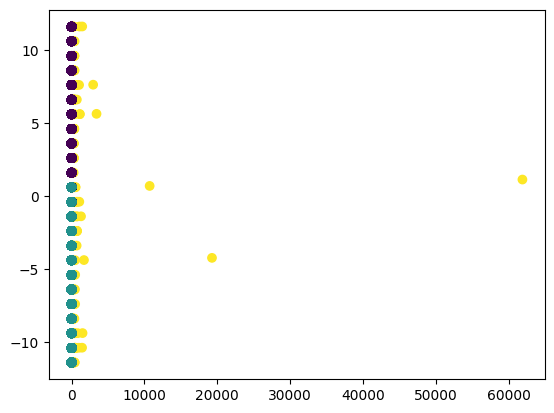

In [64]:
''' make a function to create PCA to plot 3 clusters'''

from sklearn.decomposition import PCA

def plot_3_clusters(data, n_clusters=3):
    # Create a PCA instance: pca
    pca = PCA(n_components=2)

    # Fit the PCA instance to the scaled samples
    principalComponents = pca.fit_transform(data)

    # Create a KMeans model with 3 clusters: model
    model = MiniBatchKMeans(n_clusters=n_clusters,
                             init='random',
                             n_init=10,
                             max_no_improvement=10,
                             random_state=0)

    # Use fit_predict to fit model and obtain cluster labels: labels
    labels = model.fit_predict(data)

    # Create a DataFrame with labels and varieties as columns: df
    df = pd.DataFrame({'label': labels, 'counts': data['counts'], 'hour': data['hour'], 'ratio_deny_total': data['ratio_deny_total']})

    # Create crosstab: ct
    ct = pd.crosstab(df['label'], df['hour'])

    # Display ct
    print(ct)

    # Create a scatter plot of x and y, using labels to define the colors
    fig, ax = plt.subplots()
    ax.scatter(principalComponents[:,0], principalComponents[:,1], c=labels)

    # Display the plot
    plt.show()

plot_3_clusters(unsupervised_df[['counts', 'hour', 'ratio_deny_total']])

In [65]:
''' import make pipeline '''

from sklearn.pipeline import make_pipeline

hour    0    1    2    3    4    5    6    7    8    9   ...   14   15   16  \
label                                                    ...                  
0        0    0    0    0    0    0    0    0    0    0  ...  609  578  643   
1       35   28   23   27   33   31   32   33   24   29  ...   35   34   37   
2      691  653  695  668  748  681  666  649  641  714  ...    0    0    0   

hour    17   18   19   20   21   22   23  
label                                     
0      657  656  656  679  662  651  701  
1       33   33   34   38   29   27   32  
2        0    0    0    0    0    0    0  

[3 rows x 24 columns]


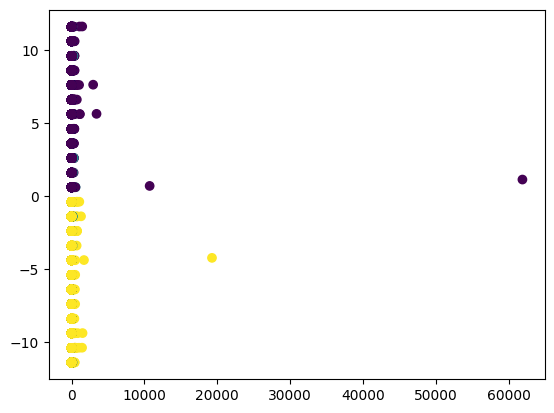

In [67]:
''' normalise the data and make a function to create PCA to plot 3 clusters'''

from sklearn.preprocessing import StandardScaler

def plot_3_clusters_norm(data, n_clusters=3):

    # Create a scaler: scaler
    scaler = StandardScaler()

    # Create a KMeans model with 3 clusters: model
    model = MiniBatchKMeans(n_clusters=n_clusters,
                             init='random',
                             n_init=10,
                             max_no_improvement=10,
                             random_state=0)

    # Create pipeline: pipeline
    pipeline = make_pipeline(scaler, model)

    # Fit the pipeline to samples
    pipeline.fit(data)

    # Calculate the cluster labels: labels
    labels = pipeline.predict(data)

    # Create a DataFrame with labels and varieties as columns: df
    df = pd.DataFrame({'label': labels, 'counts': data['counts'], 'hour': data['hour'], 'ratio_deny_total': data['ratio_deny_total']})

    # Create crosstab: ct
    ct = pd.crosstab(df['label'], df['hour'])

    # Display ct
    print(ct)

    # Create a PCA instance: pca
    pca = PCA(n_components=3)

    # Fit the PCA instance to the scaled samples
    principalComponents = pca.fit_transform(data)

    # Create a scatter plot of x and y, using labels to define the colors
    fig, ax = plt.subplots()
    ax.scatter(principalComponents[:,0], principalComponents[:,1], c=labels)

    # Display the plot
    plt.show()

plot_3_clusters_norm(unsupervised_df[['counts', 'hour', 'ratio_deny_total']])

